<a href="https://colab.research.google.com/github/alaa-32/Discovering-Rare-Genomic-Subtypes-from_RNA-seq/blob/main/pan_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Libraries
!pip -q install umap-learn statsmodels --upgrade

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from scipy.special import comb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import umap
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [ ]:
# Load the csv data from the specified path
df1 = pd.read_csv("/content/data.csv")
print(df1.shape)
df1

(801, 20532)


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,sample_796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,sample_797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,sample_798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,sample_799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [ ]:
# Load the csv data from the specified path
df2 = pd.read_csv("/content/labels.csv")
print(df2.shape)
df2

(801, 2)


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA
...,...,...
796,sample_796,BRCA
797,sample_797,LUAD
798,sample_798,COAD
799,sample_799,PRAD


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


# Preprocessing

## Separate Sample IDs from Features

In [ ]:
# Identify shared ID column
common_cols = list(set(df1.columns).intersection(df2.columns))
assert len(common_cols) > 0, "No common ID column found between data.csv and labels.csv"
ID_COL = "Unnamed: 0" if "Unnamed: 0" in common_cols else common_cols[0]

# Align by ID using an inner merge to keep only common sample IDs
merged_df = pd.merge(df1, df2, on=ID_COL, how='inner')

# Separate sample IDs from features and labels
X_df = merged_df.set_index(ID_COL).drop(columns=['Class']).copy()
Y_df = merged_df.set_index(ID_COL)['Class'].to_frame().copy()


# Keep only numeric gene columns
X_df = X_df.select_dtypes(include=[np.number])

print("Samples:", X_df.shape[0], "Genes:", X_df.shape[1])
X_df.head(3)

Samples: 801 Genes: 20531


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0


In [ ]:
# RNA-seq best practice: log1p if all values non-negative
X = X_df.values
if np.all(np.isfinite(X)) and np.min(X) >= 0:
    X = np.log1p(X)

# Keep top-N most variable genes to denoise & speed up (tune N if GPU is strong)
TOP_N = min(2000, X.shape[1])   # try 3000–5000 on A100 if you like
variances = X.var(axis=0)
top_idx = np.argsort(variances)[-TOP_N:]
X = X[:, top_idx]
gene_names = X_df.columns.to_numpy()[top_idx]

print(f"After variance filter: {X.shape[0]} samples × {X.shape[1]} genes")


After variance filter: 801 samples × 2000 genes


## Scale the Data

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

print("Scaled matrix:", X_scaled.shape, "mean≈", np.mean(X_scaled).round(3), "std≈", np.std(X_scaled).round(3))


Scaled matrix: (801, 2000) mean≈ -0.0 std≈ 1.0


## Build PyTorch Dataset & Dataloader

>Create a Dataset class wrapping gene expression data.

>Use DataLoader for batching and shuffling.

**Expected Result**: Efficient batching for training autoencoder on GPU/CPU.

In [ ]:
# Dataset wrapper
class GeneDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i]

# Split train/val
from sklearn.model_selection import train_test_split
SEED = 42 # Define SEED
X_tr, X_va = train_test_split(X_scaled, test_size=0.15, random_state=SEED)

train_ds = GeneDataset(X_tr)
val_ds   = GeneDataset(X_va)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = torch.utils.data.DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)

(680, 121)

# Define the Autoencoder Architecture+Training Setup

## Define Autoencoder Architecture

>Encoder: compresses 20k+ genes → 128-dimensional latent vector.

>Decoder: reconstructs original gene expressions from latent vector.

>Latent space represents compressed gene expression patterns.

**Expected Result**: Trained autoencoder with latent vectors capturing most variance.

In [ ]:
D_IN = X_scaled.shape[1]
LATENT = 128  # as requested
H1 = min(1024, max(256, D_IN//2))
H2 = min(512,  max(128, D_IN//4))

class AutoEncoder(nn.Module):
    def __init__(self, d_in, h1, h2, d_lat):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, h1), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, d_lat)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_lat, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Linear(h1, d_in)
        )
    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out, z

ae = AutoEncoder(D_IN, H1, H2, LATENT).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
crit = nn.MSELoss()


## Train Autoencoder

>Loss: MSE (reconstruction error).

>Optimizer: Adam.

>Epochs: 50+ (adjust based on convergence).

>Check loss curve to ensure learning.

**Expected Result**: Low reconstruction error → latent space is meaningful.

Epoch 001: train 0.9894 | val 0.8781
Epoch 005: train 0.6006 | val 0.6047
Epoch 010: train 0.5289 | val 0.5467
Epoch 015: train 0.4991 | val 0.5255
Epoch 020: train 0.4708 | val 0.5114
Epoch 025: train 0.4410 | val 0.4948
Epoch 030: train 0.4112 | val 0.4782
Epoch 035: train 0.3833 | val 0.4712
Epoch 040: train 0.3573 | val 0.4681
Epoch 045: train 0.3291 | val 0.4686
Epoch 050: train 0.3034 | val 0.4719
Epoch 055: train 0.2794 | val 0.4779
Early stopping.


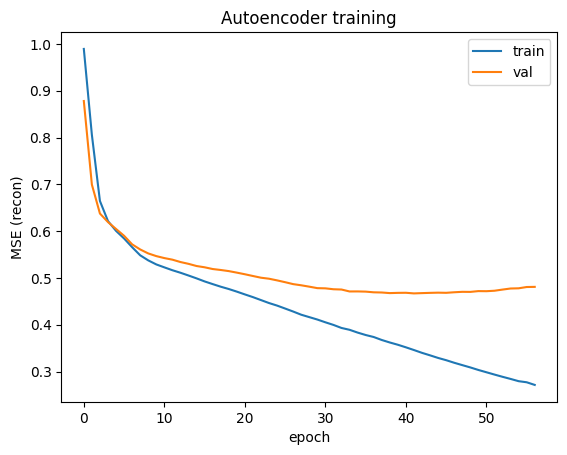

In [ ]:
EPOCHS = 100
PATIENCE = 15

best_val = np.inf
best_state = None
no_improve = 0
tr_hist, va_hist = [], []

for ep in range(1, EPOCHS+1):
    # train
    ae.train()
    tl = 0.0
    for xb in train_dl:
        xb = xb.to(DEVICE, non_blocking=True)
        opt.zero_grad()
        recon, _ = ae(xb)
        loss = crit(recon, xb)
        loss.backward()
        opt.step()
        tl += loss.item() * xb.size(0)
    tl /= len(train_ds)

    # val
    ae.eval()
    vl = 0.0
    with torch.no_grad():
        for xb in val_dl:
            xb = xb.to(DEVICE, non_blocking=True)
            recon, _ = ae(xb)
            loss = crit(recon, xb)
            vl += loss.item() * xb.size(0)
    vl /= len(val_ds)

    tr_hist.append(tl); va_hist.append(vl)

    if vl < best_val - 1e-6:
        best_val = vl
        best_state = ae.state_dict()
        no_improve = 0
    else:
        no_improve += 1

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:03d}: train {tl:.4f} | val {vl:.4f}")

    if no_improve >= PATIENCE:
        print("Early stopping.")
        break

# Load best
if best_state is not None:
    ae.load_state_dict(best_state)

# Plot learning curve
plt.plot(tr_hist, label="train"); plt.plot(va_hist, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE (recon)"); plt.title("Autoencoder training"); plt.legend(); plt.show()


## Extract Latent Representations

>Use encoder output as compressed features for clustering.

**Expected Result**: Latent vectors (samples × latent_dim).

In [ ]:
ae.eval()
with torch.no_grad():
    Z = []
    dl = torch.utils.data.DataLoader(GeneDataset(X_scaled), batch_size=512, shuffle=False)
    for xb in dl:
        xb = xb.to(DEVICE, non_blocking=True)
        _, z = ae(xb)
        Z.append(z.cpu().numpy())
Z = np.vstack(Z)
print("Latent shape:", Z.shape)  # (samples × LATENT)


Latent shape: (801, 128)


# Cluster the Latent Space

>Use KMeans (or DBSCAN for density-based clustering).

>Start with n_clusters = 5 (roughly equal to number of known cancer types).


**Expected Result**: Each sample assigned to a cluster in latent space.

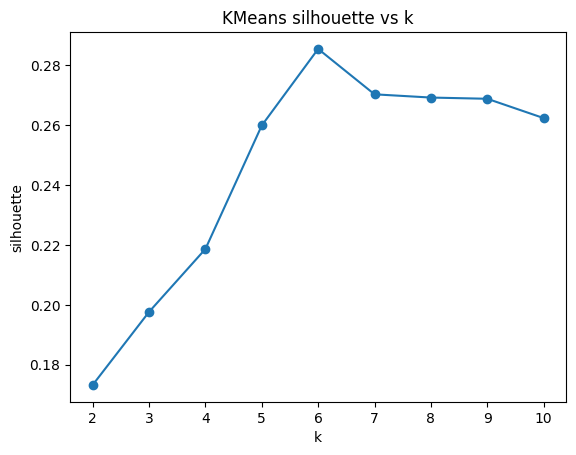

Best k = 6 (silhouette=0.285)


,size,rare
cluster,,
0,240,False
1,136,False
2,65,False
3,136,False
4,145,False
5,79,False


In [ ]:
Ks = list(range(2, 11))
sils = []
fits = {}

for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    lab = km.fit_predict(Z)
    s = silhouette_score(Z, lab)
    sils.append(s); fits[k] = (km, lab)

plt.plot(Ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("silhouette"); plt.title("KMeans silhouette vs k")
plt.show()

best_k = Ks[int(np.argmax(sils))]
km, km_labels = fits[best_k]
print(f"Best k = {best_k} (silhouette={max(sils):.3f})")

clusters = pd.Series(km_labels, index=X_df.index, name="cluster")
cluster_summary = clusters.value_counts().sort_index().to_frame("size")
rare_threshold = max(1, int(0.05 * len(clusters)))  # ≤5% cohort = rare
cluster_summary["rare"] = cluster_summary["size"] <= rare_threshold
cluster_summary


# K-Means stability (Jaccard per cluster)

In [ ]:
# ---- K-Means stability: Jaccard per cluster across 20 seeds
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

SEED = 42

def relabel_with_hungarian(lab_ref, lab_pred):
    A = pd.crosstab(lab_ref, lab_pred)
    cost = A.max().sum() - A.values
    r,c = linear_sum_assignment(cost)
    mapping = {A.index[i]: A.columns[j] for i,j in zip(r,c)}
    return np.array([mapping.get(x, x) for x in lab_pred])

def kmeans_stability(Z, k, runs=20, seed=SEED):
    labs=[]
    for s in range(runs):
        km = KMeans(k, n_init=10, random_state=seed+s).fit(Z)
        labs.append(km.labels_)
    labs = np.array(labs)
    aligned = [labs[0]]
    for r in range(1, labs.shape[0]):
        aligned.append(relabel_with_hungarian(labs[0], labs[r]))
    aligned = np.vstack(aligned)

    ref = aligned[0]
    jacc = {}
    for c in np.unique(ref):
        idx = (ref==c)
        vals=[]
        for r in range(aligned.shape[0]):
            best=0.0
            for cp in np.unique(aligned[r]):
                idxp = (aligned[r]==cp)
                inter = (idx & idxp).sum()
                union = (idx | idxp).sum()
                best = max(best, inter / max(1, union))
            vals.append(best)
        jacc[c] = float(np.mean(vals))
    return jacc

# inputs expected: Z (your latent) and km_labels (your chosen k labels)
jacc = kmeans_stability(Z, k=best_k, runs=20, seed=SEED)

sizes = pd.Series(km_labels).value_counts().sort_index()
stab_km = pd.DataFrame({
    "method": "kmeans",
    "cluster": sizes.index,
    "size": sizes.values,
    "prevalence": sizes.values / len(km_labels),
    "stability_jaccard": [jacc.get(int(c), np.nan) for c in sizes.index]
}).assign(
    is_rare_lt10=lambda d: d["prevalence"] < 0.10,
    is_stable_ge60=lambda d: d["stability_jaccard"] >= 0.60
)

display(stab_km.sort_values("cluster"))


,method,cluster,size,prevalence,stability_jaccard,is_rare_lt10,is_stable_ge60
0,kmeans,0,240,0.299625,0.998347,False,True
1,kmeans,1,136,0.169788,1.000000,False,True
2,kmeans,2,65,0.081149,0.993938,True,True
3,kmeans,3,136,0.169788,1.000000,False,True
4,kmeans,4,145,0.181024,1.000000,False,True
5,kmeans,5,79,0.098627,1.000000,True,True


In [ ]:
OUTDIR = "/content/outputs"; import os; os.makedirs(OUTDIR, exist_ok=True)
stab_km.to_csv(f"{OUTDIR}/stability_kmeans.csv", index=False)


In [ ]:
# Class vs cluster association
tab = pd.crosstab(Y_df.loc[X_df.index, "Class"], km_labels)
print(tab)

# Normalize by row to see dominance
display(pd.crosstab(Y_df.loc[X_df.index, "Class"], km_labels, normalize='index').round(2))

# Chi-square + Cramér’s V
from scipy.stats import chi2_contingency
import numpy as np

chi2, p, dof, expected = chi2_contingency(tab.values)
n = tab.values.sum()
phi2 = chi2 / n
r, k = tab.shape
cramers_v = np.sqrt(phi2 / max((k-1), (r-1)))
print(f"Chi2 p={p:.2e} | Cramér's V={cramers_v:.3f}")

# standardized residuals heatmap values
std_resid = (tab.values - expected) / np.sqrt(expected + 1e-12)
std_resid[:5,:5]

col_0    0    1   2    3    4   5
Class                            
BRCA   240    0  60    0    0   0
COAD     0    0   0    0    0  78
KIRC     0    0   1    0  145   0
LUAD     0    0   4  136    0   1
PRAD     0  136   0    0    0   0


col_0,0,1,2,3,4,5
Class,,,,,,
BRCA,0.8,0.0,0.20,0.00,0.00,0.00
COAD,0.0,0.0,0.00,0.00,0.00,1.00
KIRC,0.0,0.0,0.01,0.00,0.99,0.00
LUAD,0.0,0.0,0.03,0.96,0.00,0.01
PRAD,0.0,1.0,0.00,0.00,0.00,0.00


Chi2 p=0.00e+00 | Cramér's V=0.887


array([[15.83311847, -7.13696922,  7.22644396, -7.13696922, -7.36933621],
       [-4.83433413, -3.63915453, -2.51586725, -3.63915453, -3.75763891],
       [-6.61402437, -4.97885667, -3.15152265, -4.97885667, 23.06389303],
       [-6.49978392, -4.89285958, -2.20007066, 22.90274699, -5.05216237],
       [-6.38349933, 23.49661967, -3.32207838, -4.80532372, -4.96177649]])